# Clustering Beijing Apartments/Houses 

## Table of contents
* [Introduction](#Introduction)
* [Data](#Data)
  * [Data Explaination](#explaination)
  * [Data Acquisition](#acquisition)
  * [Amap Api](#apis)
  * [Data Cleaning](#cleaning)
* [Analyztion](#Analyztion)
  * [Beijing Map](#beijing_map)
  * [Beijing Houses Distribution](#beijing_houses_distribution)
  * [Normalize Data](#normalize_data)
  * [Apply KMeans](#K_means)
  * [Cluster Houses](#cluster_houses)
- [Conclusion](#Conclusion)

## Introduction

In this project. I will choose real estate of Beijing to study as my research target to study. As one of the metropolises in the world, has 16 districts and covers around 6336 square miles. However, there are 21.54 million people lived in this city.[ https://simple.wikipedia.org/wiki/Beijing] Since 2008, China property price are increasing tremendously. Until today, the average price of house in Beijing has tripled.[ https://www.ceicdata.com/en/china/nbs-property-price-monthly/property-price-ytd-avg-beijing] Considering the average salary of Chinese, buying a house could put you in debt for life. For this reason, this project will analyze Beijing house price and its relevant factors to find out different classes of houses.

## Data

In order to find the most suitable houses for different types of people, I need to collect house data through authoritative website. In this project, I will use web crawler to collect data from LianJia[ https://bj.fang.lianjia.com/] which is a housing trading platform in China. 

### Data Explaination<a id="explaination"></a>
In addition to the homes price and areas, there are lots of other features that affect whether people choose a house or not. As mentioned before, Beijing is so big that the distance between home and the city center will be one of the major factors. Besides the distance, public transportation capacity affects the traffic circumstance directly, so I also need to check if there is a subway station near the home or not. In the other hand, for most Chinese families, they attach great importance to the education of next generation, so I have enough evidence to show that school-nearby homes have higher value in both living and investment. Last, but not the least, Beijing's medical level is the one of the best in China, more medical facilities around homes means better treatment condition for any kind of disease.

In our project, we consider following features as the most critical parts while people buying a home. 
- House's Price
- House's Area
- Distance to the city center(TianAnMen Square)
- Hospital numbers within 1000 meters
- School numbers within 1000 meters
- Subyway numbers within 1000 meters
- New or second-hand houses

### Data Acquisition<a id="acquisition"></a>


To collect house data, we need to use web spider to crawl from LianJia's website. from the website we will be able to download houses' name, price and areas. After that we need to use Amap APIs to collect houses' latitude and longitude, distance to the city center, and other pois.

#### import modules for crawling

In [1]:
import requests
from fake_useragent import UserAgent
from pyquery import PyQuery as pq
import numpy as np
import pandas as pd
import re, json
from tqdm import tqdm

we use fake_useragent library to generate a random user agent for requests method. We will donwload new houses data from Lianjia. The base url is https://bj.fang.lianjia.com/loupan/, each webpage contain 10 new houses information, we will add the '/pgi/' where i is the page number, at the end of base url. By download the data on each page through this function, we will be able to collect all new house data. We will also initialize the data frame to store the house data. Then, we use the pyquery library, which is a jQuery-like library for querying xml documents, analyzing the downloaded html files, and extracting the house information we want from them.

In [2]:
ua = UserAgent(verify_ssl=False)
headers = {'User-Agent':ua.random}
url = "https://bj.fang.lianjia.com/loupan/"

# house_data_list = []
HouseDF = pd.DataFrame(columns=["name","price","unit","areas","distinct","address","type"])

#### New houses crawler

For new homes, the information we can get includes the name, price, area, address of the home and the district to which it belongs. Home prices may be in different units, or they may be average or total prices. To ensure that all data is in the same format, I wrote 4 functions to change all home prices to the same unit and download them:

- **get_onepage_houses**: the page crawler, which can download houses' data of one webpage(10 houses detail data in each page).
- **get_pages**: a loop function that use get_onepage_houses to download all pages.
- **extrect_HousesArea**: since new houses usually has different house type which result differnt size. This function will extract all size.
- **find_lowestArea**:  The price of some homes is marked as the total price, and after browsing the website, I found that the total price corresponds to the minimum house size. Therefore, this feature is to obtain the minimum area of a house.

In [3]:
# make two functions for extract NewHouseArea range and the lowestArea
def extract_HouseArea(houseArea):
    pattern = re.compile("[0-9]+")
    areas = re.findall(pattern,houseArea)
    return areas

def find_lowestArea(areaList):    
    if areaList != []:
        return areaList[0]
    else:
        return "tbd"

In [4]:
# get one page houses details
house_data_list = [] #list for each page houses' data in type of dataframe
def get_onepage_house(url):
    r = requests.get(url, timeout =10, headers = headers)
    if r.status_code == 200:
        r.encoding = r.apparent_encoding
        doc = pq(r.text)
        one_house = {}
        list_houses = doc("ul.resblock-list-wrapper > li > div")
        for house in list_houses.items():
            item = pq(house.html())
            name = item("div.resblock-name > a")
            unit = item("div.resblock-price > div.main-price > span.desc")
            tempArea = item("div > div.resblock-area > span").text()
            areaList = extract_HouseArea(tempArea)
            areaStr = ",".join(areaList)
            lowestArea = find_lowestArea(areaList)
            tempPrice = item("div.resblock-price > div.main-price > span.number").text()
            if "总价" in unit.text() and (lowestArea !='tbd'):
                price = float(tempPrice)*10000/float(lowestArea)
            else:
                price = tempPrice
            distinct = item("div.resblock-location > span:nth-child(1)")
            address = item("div.resblock-location > a")
            ifNewHouse = 1
            houseData = {"name":name.text(),"price":price,"unit":"RMB/㎡","areas":areaStr,"distinct":distinct.text(),"address":address.text(),"type":ifNewHouse}
            oneHouseDF = pd.DataFrame(houseData,columns=["name","price","unit","areas","distinct","address","type"],index=[0])
            # one webpage house data make a dataframe, and then all dataframe will be append to a list of dataframe which including all houses' data. In the end we will use pd.concat method to construct a Large DataFrame for new houses.
            house_data_list.append(oneHouseDF)

        
# loop function
def get_pages(baseUrl, pages):
    pbar = tqdm(total=100)
    for i in range(1,pages):
        pbar.update((1/(pages-1))*100)
        urlend = "pg" + str(i) + "/"
        compUrl = baseUrl +urlend
        get_onepage_house(compUrl)
    pbar.close()
    newHouseDF = pd.concat(house_data_list,ignore_index=True)
    return newHouseDF

In [5]:
rawNewHousesDF = get_pages(url,19)
# rawNewHousesDF.to_csv('rawNewHousesDF.csv',index=False)
rawNewHousesDF.head()

100.00000000000001it [00:59,  1.60it/s]                         


,name,price,unit,areas,distinct,address,type
0,天恒水岸壹号,54054.1,RMB/㎡,"185,199",房山,良乡大学城西站地铁南侧400米，刺猬河旁,1
1,观唐云鼎,28362.6,RMB/㎡,171,密云,溪翁庄镇密溪路39号院（云佛山度假村对面）,1
2,运河铭著,46000,RMB/㎡,"100,140",通州,商通大道与榆东一街交叉口，温榆河森林公园东500米,1
3,万年广阳郡九号,48500,RMB/㎡,"139,166",房山,长阳清苑南街与汇商东路交汇处西北角,1
4,华远裘马四季,60000,RMB/㎡,"150,191",门头沟,增产路16号院,1


In [6]:
print('There are %s new houses data downloaded' %str(rawNewHousesDF.shape[0]))

There are 180 new houses data downloaded


#### Second-hand houses crawler

For second-hand homes, we can get the same data as new homes. The difference is that the price of second-hand housing is displayed as the average price, we do not need the price conversion function. However, we still have to use regular expressions to extract the size of the house. At the same time, different homeowners in the same community can sell their homes at different prices. We also need a function to calculate the average price of a community. Therefore, for second-hand housing, we have 4 functions in total:

- **extract_shHousesArea**: using regex to filter out non numeric characters of houses' areas.
- **get_secondhand_page_houses**: the page crawler, which can download house data of one webpage(30 houses detail data in each page) 
- **get_pages_secondHand**: a loop function that use get_secondhand_page_houses to download all pages.
- **combineSameHouseName**: calculate the average price of one community.

In [7]:
# extract second-hand houses Areas
def extract_shHousesArea(houseDetail):
    pattern = re.compile('[\d+\.]+平米')
    tempArea = re.findall(pattern, houseDetail)
    areaList = "".join(tempArea)
    area = areaList.replace("平米","")
    return area

In [8]:
# Second-Hand Houses MainFunction
secondHandHouseList = []
def get_secondhand_page_houses(url):
    r = requests.get(url, timeout =10, headers = headers)
    if r.status_code == 200:
        r.encoding = r.apparent_encoding
        doc = pq(r.text)
        one_house = {}
        pricePattern = re.compile('[0-9]+')
        list_houses = doc("#content > div.leftContent > ul > li")
        for house in list_houses.items():
            item = pq(house.html())
            name = item("div.info.clear > div.flood > div > a:nth-child(2)")
            preprice = item("div.info.clear > div.priceInfo > div.unitPrice > span")
            priceExtract = re.findall(pricePattern,preprice.text())
            if len(priceExtract) != 0:
                price = priceExtract[0]
            else:
                price = "empty"
            houseDetail = item("div.info.clear > div.address > div").text()
            area = extract_shHousesArea(houseDetail)
            unit = "RMB/m²"
            distinct = "tbd"
            address = "tbd"
            ifNewHouse = 0
            houseData = {"name":name.text(),"price":price,"unit":unit,"areas":area,"distinct":distinct,"address":address,"type":ifNewHouse}
            oneHouseDF = pd.DataFrame(houseData,columns=["name","price","unit","areas","distinct","address","type"],index=[0])
            secondHandHouseList.append(oneHouseDF)


In [9]:
secondHandUrl="https://bj.lianjia.com/ershoufang/"
def get_pages_secondHand(baseUrl, pages):
    pbar = tqdm(total=100)
    for i in range(1,pages):
        urlend = "pg" + str(i) + "/"
        compUrl = baseUrl +urlend
#         print('%s hosues data has downloaded' %str(len(secondHandHouseList)))
        get_secondhand_page_houses(compUrl)
        pbar.update((1/(pages-1))*100)
    pbar.close()
    SHHouseDF = pd.concat(secondHandHouseList,ignore_index=True)
    return SHHouseDF

second-hand cralwer start 

In [10]:
unsortedSecondhandDF = get_pages_secondHand(secondHandUrl, 101)

100%|██████████| 100.0/100 [04:08<00:00,  2.51s/it]


In [11]:
def combineSameHouseName(dfName):
    dfName = dfName[dfName['price'] != 'empty'].copy()
    dfName[['price']] = dfName[['price']].astype(float).copy()
    pricePart = dfName.groupby(dfName['name'])['price'].mean().reset_index().copy()
    commonPart = dfName.drop_duplicates('name')
    commonPart.drop('price',axis=1,inplace=True)
    combinedDF = pd.merge(pricePart,commonPart,on='name',how='outer')
    return combinedDF

In [12]:
rawSecondhandHousedsDF = combineSameHouseName(unsortedSecondhandDF)
# rawSecondhandHousedsDF.to_csv('rawSecondhandHousedsDF.csv')

/home/phi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
rawSecondhandHousedsDF

,name,price,unit,areas,distinct,address,type
0,10AM新坐标,69548.5,RMB/m²,27.62,tbd,tbd,0
1,11站,44736.0,RMB/m²,47.39,tbd,tbd,0
2,621小区,77907.0,RMB/m²,43,tbd,tbd,0
3,8哩岛,42588.0,RMB/m²,204.91,tbd,tbd,0
4,BOBO自由城,52478.0,RMB/m²,123.1,tbd,tbd,0
...,...,...,...,...,...,...,...
1792,龙锦苑东二区,35660.0,RMB/m²,124.79,tbd,tbd,0
1793,龙锦苑东五区,37583.0,RMB/m²,125.31,tbd,tbd,0
1794,龙锦苑东四区,40507.0,RMB/m²,124.67,tbd,tbd,0
1795,龙锦苑二区,50114.0,RMB/m²,88.4,tbd,tbd,0


In [14]:
print('There are %s second-hand houses data downloaded' %str(rawSecondhandHousedsDF.shape[0]))

There are 1797 second-hand houses data downloaded


### Amap Api<a id="apis"></a>

Amap is one of the map services companies in China, which provides a large number of map services and APIs. In this project, I will just the poi API to get these factors including house’s price, house’s area, the distance to city center, the number of hospitals, schools and subway stations within 1000 meters. 

In [15]:
#setting up locaiton data baseApi, type equal to 120000 which means result will only show hosues.
locationBaseApi = "https://restapi.amap.com/v3/place/text?key=59d76f9270ae6222f20be27206322c48&keywords={keywords}&types=120000&city=北京&children=0&offset=20&page=1&extensions=all"
def amap_poi_func(keywords):
    makedApi = locationBaseApi.format(keywords=keywords)
    response = requests.get(makedApi).json()
    return response

def add_locaiton_data(DfName,DfRowIndex,poidata):
    if poidata['pois'] != []:
        location = poidata['pois'][0]['location'].split(',',1)
        latitude = location[1]
        longitude = location[0]
        distinct = poidata['pois'][0]['adname']
        if poidata['pois'][0]['address'] != []:
            address = poidata['pois'][0]['address']
        else:
            address = "tbd"
        DfName.loc[DfRowIndex,'distinct'] = distinct
        DfName.loc[DfRowIndex,'address'] = address
        DfName.loc[DfRowIndex,'latitude'] = latitude
        DfName.loc[DfRowIndex,'longitude'] = longitude

def completeDFLocation(DfName,startrow,endrow):
    pbar = tqdm(total=100)
    for i in range(startrow,endrow):
        keywords = DfName.loc[i,'name']
        locationJson = amap_poi_func(keywords)
        add_locaiton_data(DfName,i,locationJson)
        pbar.update((1/(endrow-startrow))*100)
    pbar.close()

get new and second-hand houses location data

In [16]:
completeDFLocation(rawNewHousesDF,0,len(rawNewHousesDF))
print('%d new houses location data downloaded' %rawNewHousesDF.size)
completeDFLocation(rawSecondhandHousedsDF,0,len(rawSecondhandHousedsDF))
print('%d second-hand houses location data downloaded' %rawSecondhandHousedsDF.size)

100.00000000000023it [00:24,  4.06it/s]                         
  0%|          | 0.05564830272676684/100 [00:00<03:25,  2.06s/it]

1620 new houses location data downloaded


100%|█████████▉| 99.99999999999866/100 [04:11<00:00,  2.52s/it]  

16173 second-hand houses location data downloaded


#### Comibne New and Second-hand houses dataframe.

In [17]:
rawCombineDF = pd.concat([rawNewHousesDF,rawSecondhandHousedsDF],axis=0,sort=False)
rawCombineDF.reset_index(drop=True,inplace=True)
# rawCombineDF.to_csv("rawCombineDF.csv",index=False)

,name,price,unit,areas,distinct,address,type,latitude,longitude
0,天恒水岸壹号,54054.1,RMB/㎡,"185,199",房山区,揽秀南大街与良乡东街交叉口,1,39.714265,116.155789
1,观唐云鼎,28362.6,RMB/㎡,171,密云区,密关路与701乡道交叉口西北100米,1,40.427632,116.831226
2,运河铭著,46000,RMB/㎡,"100,140",通州区,永顺镇商通大道与榆东一街交口,1,39.951533,116.652210
3,万年广阳郡九号,48500,RMB/㎡,"139,166",房山区,汇商东路,1,39.719431,116.193375
4,华远裘马四季,60000,RMB/㎡,"150,191",门头沟区,新桥大街西侧,1,39.94244,116.097612
...,...,...,...,...,...,...,...,...,...
1972,龙锦苑东二区,35660,RMB/m²,124.79,昌平区,龙锦苑东2区,0,40.08602,116.368381
1973,龙锦苑东五区,37583,RMB/m²,125.31,昌平区,回龙观龙锦三街,0,40.086315,116.37421
1974,龙锦苑东四区,40507,RMB/m²,124.67,昌平区,"回龙观霍营城铁北侧,龙锦苑东四区(近龙锦三街)",0,40.083405,116.374472
1975,龙锦苑二区,50114,RMB/m²,88.4,昌平区,昌平回龙观龙锦苑二区,0,40.088405,116.355917


In [18]:
#rawCombineDF.to_csv("rawCombineDF.csv",index=False)

#### Use AmpApi to get poi data including numbers of subway station, hospital, schools

In [19]:
def getAroundDetails(location):
    #key = 59d76f9270ae6222f20be27206322c48
    #包含学校：高等院校141201，中学141202，小学141203，幼儿园141204、医院：三级甲等医院090101，专科医院090200、地铁站150500、商场060100
    #poitype=''
    baseApi = 'https://restapi.amap.com/v3/place/around?key=59d76f9270ae6222f20be27206322c48&location={location}&keywords=&types=141201|141202|141203|141204|090101|090200|150500|060100&radius=1000&offset=20&page=1&extensions=all'
    compeltedApi = baseApi.format(location = location)
    response = requests.get(compeltedApi).json()
    return response

def AddAroundDetail(poijson,DFname,DFrowIndex):
    schoolNumber = 0
    schoolList = []
    subwayNumber = 0
    subwayList = []
    hospitalNumber = 0
    hospitalList = []
    if 'pois' in poijson.keys():
        for position in poijson['pois']:
            if "学校" in position['type']:
                schoolNumber += 1
                schoolList.append(position['name'])
            if "地铁" in position['type']:
                subwayNumber += 1
                subwayList.append(position['name'])
            if "医院" in position['type']:
                hospitalNumber += 1
                hospitalList.append(position['name'])
    DFname.loc[DFrowIndex,'schoolNumber'] = schoolNumber
    DFname.loc[DFrowIndex,'schoolList'] = ','.join(schoolList)
    DFname.loc[DFrowIndex,'subwayNumber'] = subwayNumber
    DFname.loc[DFrowIndex,'subwayList'] = ','.join(subwayList)
    DFname.loc[DFrowIndex,'hospitalNumber'] = hospitalNumber
    DFname.loc[DFrowIndex,'hospitalList'] = ','.join(hospitalList)

def Loop_AroundDetail(DFName,startRow,EndRow):
    pbar = tqdm(total=100)
    for i in range(startRow,EndRow):
        locationdata = str(DFName.loc[i,'longitude']) + ',' + str(DFName.loc[i,'latitude'])
        poijson = getAroundDetails(locationdata)
        AddAroundDetail(poijson,DFName,i)
        pbar.update((1 / (EndRow - 1)) * 100)
    pbar.close()
        

In [20]:
Loop_AroundDetail(rawCombineDF,0,len(rawCombineDF))


100.05060728745258it [05:07,  2.63s/it]                          


The data look like

#### Use AmpApi to get the distance between houses and the city center

We choose the simpleast way to measure the distance between houses and the city center, the straight-line distance which evaluate by meters.

In [21]:
def distance_functiuon(originLocation):
    #key = 59d76f9270ae6222f20be27206322c48
    #destLocation天安门:116.397477,39.908692
    baseApi = 'https://restapi.amap.com/v3/distance?key=59d76f9270ae6222f20be27206322c48&origins={originLocation}&destination=116.397477,39.908692&type=0'
#     print(baseApi)
    completedApi = baseApi.format(originLocation=originLocation)
    response = requests.get(completedApi).json()
    return response

def extract_distance(distanceJson,DFName,DFRow):
    if 'results' in distanceJson.keys():
        distance = distanceJson['results'][0]['distance']
        DFName.loc[DFRow,'distance'] = distance
    
def loop_distance(DFName,startRow,EndRow):
    pbar = tqdm(total=100)
    for i in range(startRow,EndRow):
        distancedata = str(DFName.loc[i,'longitude']) + ',' + str(DFName.loc[i,'latitude'])
        distanceJson = distance_functiuon(distancedata)
        extract_distance(distanceJson,DFName,i)
        pbar.update((1 / (EndRow - 1)) * 100)
    pbar.close()

In [22]:
loop_distance(rawCombineDF,0,len(rawCombineDF))

100.05060728745258it [02:25,  1.46s/it]                          


After getting distance data

In [23]:
rawCombineDF.head()

,name,price,unit,areas,distinct,address,type,latitude,longitude,schoolNumber,schoolList,subwayNumber,subwayList,hospitalNumber,hospitalList,distance
0,天恒水岸壹号,54054.1,RMB/㎡,"185,199",房山区,揽秀南大街与良乡东街交叉口,1,39.714265,116.155789,5.0,"良乡四小滨河校区,爱童语艺教园成长中心,北京工商大学良乡校区(西区),北京中医药大学良乡校区...",1.0,良乡大学城西(地铁站),3.0,"皓齿佳口腔,阿尔博尼(北京)口腔医院,鹏园医院",29925
1,观唐云鼎,28362.6,RMB/㎡,171,密云区,密关路与701乡道交叉口西北100米,1,40.427632,116.831226,1.0,密云区东智小学,0.0,,0.0,,68545
2,运河铭著,46000,RMB/㎡,"100,140",通州区,永顺镇商通大道与榆东一街交口,1,39.951533,116.652210,1.0,玉博睿金地幼儿园,0.0,,0.0,,22261
3,万年广阳郡九号,48500,RMB/㎡,"139,166",房山区,汇商东路,1,39.719431,116.193375,0.0,,0.0,,0.0,,27357
4,华远裘马四季,60000,RMB/㎡,"150,191",门头沟区,新桥大街西侧,1,39.94244,116.097612,8.0,"黑山小学,大峪第二小学,中国科学院幼儿园,北京市门头沟区京师实验中学,门头沟区第三幼儿园,北...",0.0,,8.0,"京西华台口腔,口腔诊所,北京京煤集团总医院感染性疾病科,北京京煤集团总医院-感染性病病科,北...",25873


In [83]:
rawCombineDF.to_csv('rawDF.csv')

In [43]:
rawCombineDF = pd.read_csv('rawDF.csv')

## Data Cleanning<a id="cleaning"></a>

ususally, data cleanning contains 5 parts:

- correcting 
- converting
- completing
- correlating
- creating


**Classify** We want to distinguish each feature if it is useful in following analysis.

In [44]:
rawCombineDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1948 entries, 0 to 1947
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1948 non-null   object 
 1   price           1948 non-null   float64
 2   unit            1948 non-null   object 
 3   areas           1941 non-null   object 
 4   distinct        1948 non-null   object 
 5   address         1948 non-null   object 
 6   type            1948 non-null   int64  
 7   latitude        1935 non-null   float64
 8   longitude       1935 non-null   float64
 9   schoolNumber    1948 non-null   float64
 10  schoolList      1907 non-null   object 
 11  subwayNumber    1948 non-null   float64
 12  subwayList      988 non-null    object 
 13  hospitalNumber  1948 non-null   float64
 14  hospitalList    1779 non-null   object 
 15  distance        1935 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 243.6+ KB


**How many data we have? and which columns have missing data**

There are 1948 row data but only 1935 rows have latitude and longitude, so we only keep non-null rows.

**Which columns are not useful?**

address, schoolList, subwayList, hospitalList and unit will not use in our analysis, we will drop them first.

**

price, areas, distance are numerical data but data type are object, we need to change their data type.

## correcting

### price

**price** column still have some incompleted data. we need to 'correct' these data. Meanwhile, houses in same community have different prices, we only going to keep the highest.

In [45]:
rawCombineDF = rawCombineDF.drop(['schoolList','subwayList','hospitalList','distinct','address','unit'],axis=1)

In [46]:
# define function for choose highest price
def drop_lowestPrice(rawDF):
    rawDF[['price']] = rawDF[['price']].copy().astype(float)
    priceDF = rawDF.groupby(rawDF['name'])['price'].max().reset_index()
    commonDF = rawDF.drop_duplicates("name") #get oth+er common columns
    commonDF.drop('price',axis=1,inplace=True)
    completedDF = pd.merge(priceDF,commonDF,on='name',how='outer')
    return completedDF

In [47]:
rawCombineDF = drop_lowestPrice(rawCombineDF).copy()

/home/phi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
rawCombineDF.head()

,name,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
0,10AM新坐标,69266.8,45.67,0,39.868745,116.443373,9.0,1.0,10.0,5928.0
1,11站,44736.0,47.39,0,39.863152,116.537697,2.0,3.0,0.0,13005.0
2,621小区,77907.0,43,0,40.031319,116.327385,11.0,1.0,4.0,14903.0
3,8哩岛,47176.0,88.78,0,39.936657,116.641781,3.0,0.0,0.0,21087.0
4,BOBO自由城,52087.5,103.58,0,39.908738,116.693575,8.0,1.0,3.0,25283.0


In [89]:

rawCombineDF['areas']=rawCombineDF['price'].astype('float64')

In [25]:
rawCombineDF['price'] = rawCombineDF[rawCombineDF['price'] != '价格待定'].copy()
rawCombineDF['price'] = rawCombineDF['price'].replace(['价格待定'],[''])

### Areas

**areas** column may contains two areas or empty, we only keep the largest one and delete empty row.

In [50]:
# choose highest areas
for i in range(1, len(rawCombineDF['areas'])):
    if (type(rawCombineDF.loc[i,'areas']) is str) and ',' in rawCombineDF.loc[i,'areas']:
        rawCombineDF.loc[i,'areas'] = max(map(float,rawCombineDF.loc[i,'areas'].split(',')))

In [52]:
rawCombineDF = rawCombineDF[rawCombineDF['areas'] != ''].copy().reset_index(drop=True)

### Nan Columns

In [54]:
rawCombineDF.isnull().sum()

name               0
price              0
areas              6
type               0
latitude          13
longitude         13
schoolNumber       0
subwayNumber       0
hospitalNumber     0
distance          13
dtype: int64

In [56]:
rawCombineDF= rawCombineDF.dropna().reset_index(drop=True)
rawCombineDF.isnull().sum()

name              0
price             0
areas             0
type              0
latitude          0
longitude         0
schoolNumber      0
subwayNumber      0
hospitalNumber    0
distance          0
dtype: int64

### change data type

In [58]:
rawCombineDF['areas'] = rawCombineDF['areas'].astype(np.float)
rawCombineDF['distance'] = rawCombineDF['distance'].astype(np.float)

In [59]:
rawCombineDF.head()

,name,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
0,10AM新坐标,69266.8,45.67,0,39.868745,116.443373,9.0,1.0,10.0,5928.0
1,11站,44736.0,47.39,0,39.863152,116.537697,2.0,3.0,0.0,13005.0
2,621小区,77907.0,43.00,0,40.031319,116.327385,11.0,1.0,4.0,14903.0
3,8哩岛,47176.0,88.78,0,39.936657,116.641781,3.0,0.0,0.0,21087.0
4,BOBO自由城,52087.5,103.58,0,39.908738,116.693575,8.0,1.0,3.0,25283.0


In [60]:
rawCombineDF.isnull().sum()

name              0
price             0
areas             0
type              0
latitude          0
longitude         0
schoolNumber      0
subwayNumber      0
hospitalNumber    0
distance          0
dtype: int64

In [61]:
rawCombineDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1898 non-null   object 
 1   price           1898 non-null   float64
 2   areas           1898 non-null   float64
 3   type            1898 non-null   int64  
 4   latitude        1898 non-null   float64
 5   longitude       1898 non-null   float64
 6   schoolNumber    1898 non-null   float64
 7   subwayNumber    1898 non-null   float64
 8   hospitalNumber  1898 non-null   float64
 9   distance        1898 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 148.4+ KB


In [63]:
HouseData = rawCombineDF

## Data Visualization

Now, we have 1898 rows valid data. We then can use matplotlib and seaborn libs to visulize our data.

In [64]:
# import visulization libs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

HouseData = pd.read_csv('Hosuedata.csv', index_col=0)

In [3]:
HouseData.head()

,name,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
0,10AM新坐标,65492.0,32.28,0,39.868745,116.443373,10.0,1.0,9.0,5928.0
1,8哩岛,44455.0,140.21,0,39.936657,116.641781,3.0,0.0,0.0,21087.0
2,BOBO自由城,53524.5,102.48,0,39.908828,116.693801,8.0,1.0,3.0,25302.0
3,CBD传奇,71839.0,65.95,0,39.887624,116.477012,6.0,1.0,12.0,7185.0
4,CBD总部公寓二期,88126.0,99.29,0,39.899629,116.454618,9.0,0.0,11.0,4982.0


## Data Correcting

In [65]:
HouseData.describe()

,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
count,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000
mean,61791.158019,97.618272,0.077450,39.922615,116.397006,9.029505,0.626976,5.780295,15297.847734
std,24956.864403,73.035254,0.267374,0.171078,0.225943,3.940808,0.700891,3.716168,22802.464492
min,15813.000000,26.500000,0.000000,34.248041,108.946018,0.000000,0.000000,0.000000,1114.000000
25%,43109.750000,61.160000,0.000000,39.866378,116.316639,6.000000,0.000000,3.000000,7591.250000
50%,56044.500000,80.800000,0.000000,39.918338,116.393693,9.000000,1.000000,6.000000,12313.500000
75%,75126.750000,107.545000,0.000000,39.978328,116.475401,12.000000,1.000000,8.000000,20163.000000
max,250000.000000,1280.000000,1.000000,40.447415,118.229828,20.000000,4.000000,18.000000,913146.000000


In [5]:
HouseData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1845 entries, 0 to 1844
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1845 non-null   object 
 1   price           1845 non-null   float64
 2   areas           1845 non-null   float64
 3   type            1845 non-null   int64  
 4   latitude        1845 non-null   float64
 5   longitude       1845 non-null   float64
 6   schoolNumber    1845 non-null   float64
 7   subwayNumber    1845 non-null   float64
 8   hospitalNumber  1845 non-null   float64
 9   distance        1845 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 158.6+ KB


In [9]:
HouseData[['type','price']].groupby('type',as_index=False).mean()

,type,price
0,0,57648.925754
1,1,59123.055514


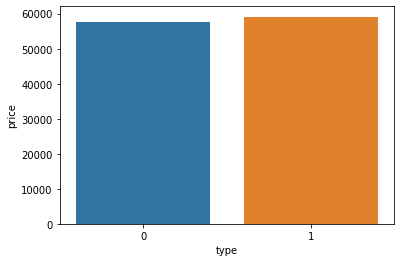

In [88]:
fig3 = plt.figure()
sns.barplot(x='type',y='price',data=HouseData[['type','price']].groupby('type',as_index=False).mean())

new houses and second houses are very similar, seems like this feature will not affeact house price a lot.

In [89]:
HouseData[['schoolNumber','price']].groupby('schoolNumber',as_index=False).mean()

,schoolNumber,price
0,0.0,50602.416316
1,1.0,46174.709226
2,2.0,48331.609752
3,3.0,48975.141180
4,4.0,50821.249223
5,5.0,50732.230287
6,6.0,55322.321837
7,7.0,58885.093667
8,8.0,59169.903523
9,9.0,58872.434787


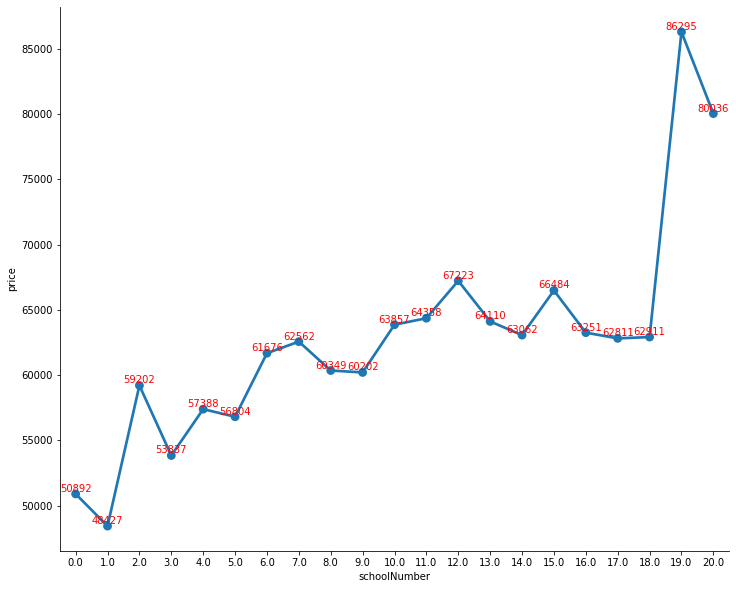

In [90]:
schooldata = HouseData[['schoolNumber','price']].groupby('schoolNumber',as_index=False).mean()
fig = plt.figure(figsize=(12,10))
ax = sns.pointplot(x='schoolNumber',y='price',data=schooldata, markers=['o'])
for a,b in zip(schooldata['schoolNumber'],schooldata['price']):
    plt.text(a,b,'%d' % b,ha='center',va='bottom', fontsize=10, color='red')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

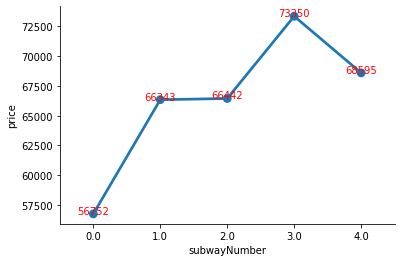

In [92]:
subdata = HouseData[['subwayNumber','price']].groupby('subwayNumber',as_index=False).mean()
ax = sns.pointplot(x='subwayNumber',y='price',data=subdata)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for a,b in zip(subdata['subwayNumber'],subdata['price']):
    plt.text(a,b,'%d' % b,ha='center',va='baseline', fontsize=10, color='red')


### discreate numerical data divided into different groups
- areas
- number of school
- number of hospitals
- number of subways
- distance

In [96]:
HouseData['areas'].describe()

count    1898.000000
mean       97.618272
std        73.035254
min        26.500000
25%        61.160000
50%        80.800000
75%       107.545000
max      1280.000000
Name: areas, dtype: float64

In [97]:
# areas divided into different groups
bins = [25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,1300]
cats = pd.cut(HouseData['areas'],bins)

In [98]:
areaSplits = pd.value_counts(cats)

In [113]:
type(areaSplits.index.astype(str)[0])

str

In [131]:
lst = [x for x in range(17)]
lst

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]'

Text(0, 0.5, 'house counts')

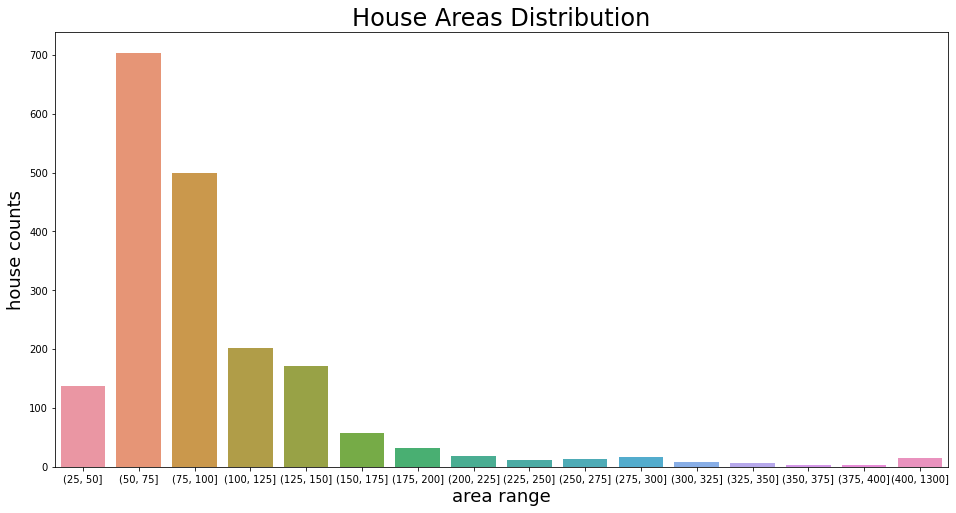

In [141]:
fig = plt.figure(figsize=(16,8))
ax = sns.barplot(x=areaSplits.index,y=areaSplits.values)
ax.set_title('House Areas Distribution',size=24)
ax.set_xlabel('area range',size=18)
ax.set_ylabel('house counts',size=18)
# for a,b in zip(areaSplits.index.astype(str),areaSplits.values):
#     plt.text(a,b,'%s' % b,ha='center',va='baseline', fontsize=10, color='red')

In [143]:
schoolCounts = HouseData['schoolNumber'].value_counts()
subwayCounts = HouseData['subwayNumber'].value_counts()
hospitalCounts = HouseData['hospitalNumber'].value_counts()

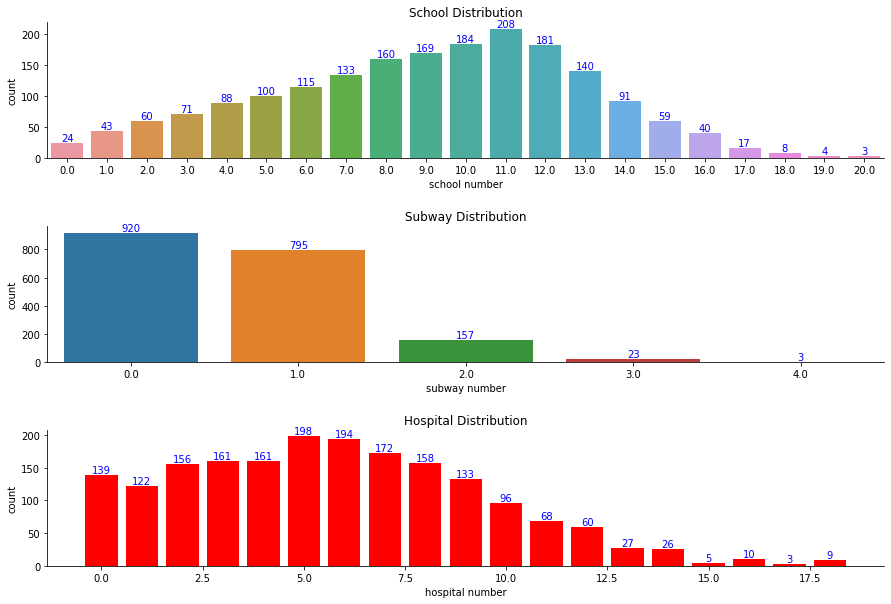

In [148]:
fig = plt.figure(figsize=(15,10))
# school axes
ax1 = fig.add_subplot(311)
ax1 = sns.barplot(x=schoolCounts.index,y=schoolCounts)
ax1.set_xlabel('school number')
ax1.set_ylabel('count')
ax1.set_title('School Distribution')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for a,b in zip(schoolCounts.index,schoolCounts):
    plt.text(a,b,'%d' % b,ha='center',va='bottom', fontsize=10,color='blue' )
# subway axes
ax2 = fig.add_subplot(312)
ax2 = sns.barplot(x=subwayCounts.index,y=subwayCounts.values)
ax2.set_xlabel('subway number')
ax2.set_ylabel('count')
ax2.set_title('Subway Distribution')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for a,b in zip(subwayCounts.index,subwayCounts):
    plt.text(a,b,'%d' % b,ha='center',va='bottom', fontsize=10,color='blue' )
# hospital axes
ax3 = fig.add_subplot(313)
ax3.bar(hospitalCounts.index, hospitalCounts,color='red')
ax3.set_xlabel('hospital number')
ax3.set_ylabel('count')
ax3.set_title('Hospital Distribution')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
for a,b in zip(hospitalCounts.index,hospitalCounts):
    plt.text(a,b,'%d' % b,ha='center',va='bottom', fontsize=10,color='blue' )
# ax3.yaxis.set_ticks(hospitalCounts)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.5)
plt.show()

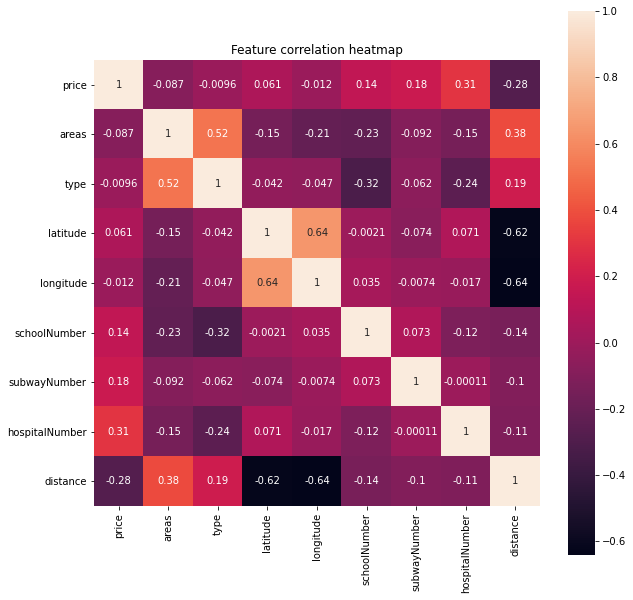

In [149]:
plt.figure(figsize=(10,10))
plt.title('Feature correlation heatmap')
sns.heatmap(HouseData.corr(),square=True,annot=True)

## Analyztion

### Beijing Map<a id="beijing_map"></a>

In [150]:
import folium

In [151]:
BJmap = folium.Map(
    location=[39.90, 116.38],
    title="Beijing Map",
    zoom_start=11)

### Beijing Houses Distribution<a id="beijing_houses_distribution"></a>

In [152]:
for log,lat,name,price  in zip(HouseData['longitude'],HouseData['latitude'],HouseData['name'],HouseData['price']):
    detail = name + "," + "Price:" + str(price) +"RMB/㎡"
    folium.vector_layers.CircleMarker(
        [lat, log],
        radius=4,
        tooltip=detail,
        fill=True,
        stroke=False,
#         color='blue',
        fill_color='blue',
        fill_opacity=0.5
    ).add_to(BJmap)
BJmap

### Normalize Data<a id="normalize_data"></a>

Our features are measured by different units, for example, price is measure by RMB and distance are measured by meters. Therefore, we use normalization method to transform all data in to range [0,1].

In [153]:
from sklearn import preprocessing
from sklearn import metrics

In [154]:
AnalyzeDF = HouseData.set_index('name').copy()
AnalyzeDF.head()

,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
name,,,,,,,,,
10AM新坐标,69266.8,45.67,0,39.868745,116.443373,9.0,1.0,10.0,5928.0
11站,44736.0,47.39,0,39.863152,116.537697,2.0,3.0,0.0,13005.0
621小区,77907.0,43.00,0,40.031319,116.327385,11.0,1.0,4.0,14903.0
8哩岛,47176.0,88.78,0,39.936657,116.641781,3.0,0.0,0.0,21087.0
BOBO自由城,52087.5,103.58,0,39.908738,116.693575,8.0,1.0,3.0,25283.0


In [155]:
normalizer = preprocessing.Normalizer().fit(AnalyzeDF)
normalizer

Normalizer(copy=True, norm='l2')

In [156]:
normData = normalizer.transform(AnalyzeDF)

In [157]:
normData

array([[9.96356050e-01, 6.56932048e-04, 0.00000000e+00, ...,
        1.43843234e-05, 1.43843234e-04, 8.52702689e-02],
       [9.60243866e-01, 1.01721112e-03, 0.00000000e+00, ...,
        6.43940361e-05, 0.00000000e+00, 2.79148146e-01],
       [9.82189611e-01, 5.42109865e-04, 0.00000000e+00, ...,
        1.26072062e-05, 5.04288247e-05, 1.87885194e-01],
       ...,
       [8.84022245e-01, 2.94752488e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.88174918e-04, 4.67426497e-01],
       [8.93983979e-01, 2.85669590e-03, 0.00000000e+00, ...,
        4.58465078e-05, 2.29232539e-04, 4.48080844e-01],
       [8.86844091e-01, 1.22681583e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.06015886e-04, 4.62059638e-01]])

### Apply KMeans <a id="K_means"></a>

In [158]:
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In order to find the best number of clusters, we can iterate with different numbers and find the largest calinski harabasz score. Also, since there are too many 

In [159]:
sc_score_list = {}
SSE = []
def KMeans_Method(num_clusters):
    k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
    k_means.fit(normData)
    labels = k_means.labels_
    sc_score = metrics.silhouette_score(normData,labels,metric='euclidean')
    SSE.append(k_means.inertia_)
    sc_score_list[sc_score] = num_clusters

In [160]:
for num_clusters in range(2,15):
    KMeans_Method(num_clusters)   
print(sc_score_list)

{0.6574232103957603: 2, 0.626698496285377: 3, 0.6079890997563601: 4, 0.6134860552245562: 5, 0.5585424042481127: 6, 0.5544015702403637: 7, 0.5395097778683603: 8, 0.5326681658241391: 9, 0.5377083539873728: 10, 0.5410241651301837: 11, 0.5441339828226206: 12, 0.5433404438188579: 13, 0.5529932540018336: 14}


In [161]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'elbow method graph')

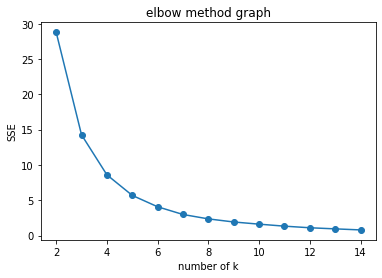

In [162]:
X = range(2,15)
fig, ax = plt.subplots()
ax.set_xlabel('number of k')
ax.set_ylabel('SSE')
ax.plot(X,SSE,'o-')
ax.set_title('elbow method graph')

In [163]:
list(sc_score_list.keys())

[0.6574232103957603,
 0.626698496285377,
 0.6079890997563601,
 0.6134860552245562,
 0.5585424042481127,
 0.5544015702403637,
 0.5395097778683603,
 0.5326681658241391,
 0.5377083539873728,
 0.5410241651301837,
 0.5441339828226206,
 0.5433404438188579,
 0.5529932540018336]

Text(0.5, 1.0, 'SC score trend')

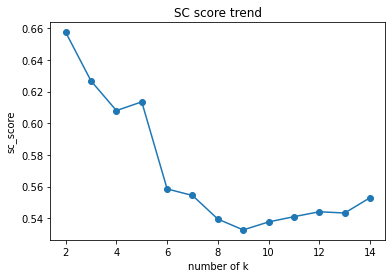

In [165]:
X = range(2,15)
fig, ax = plt.subplots()
ax.set_xlabel('number of k')
ax.set_ylabel('sc_score')
ax.plot(X,list(sc_score_list.keys()),'o-')
ax.set_title('SC score trend')

**as we can see from sc_score and elbow method** According to elbow method, we can see the best cluster number should be four or five. 

In [166]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(normData)
labels = k_means.labels_


In [167]:
AnalyzeDF['Labels'] = labels

In [168]:
AnalyzeDF.head()

,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance,Labels
name,,,,,,,,,,
10AM新坐标,69266.8,45.67,0,39.868745,116.443373,9.0,1.0,10.0,5928.0,1
11站,44736.0,47.39,0,39.863152,116.537697,2.0,3.0,0.0,13005.0,3
621小区,77907.0,43.00,0,40.031319,116.327385,11.0,1.0,4.0,14903.0,1
8哩岛,47176.0,88.78,0,39.936657,116.641781,3.0,0.0,0.0,21087.0,2
BOBO自由城,52087.5,103.58,0,39.908738,116.693575,8.0,1.0,3.0,25283.0,2


In [169]:
AnalyzeDF.reset_index('name',inplace=True)
AnalyzeDF.head()

,name,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance,Labels
0,10AM新坐标,69266.8,45.67,0,39.868745,116.443373,9.0,1.0,10.0,5928.0,1
1,11站,44736.0,47.39,0,39.863152,116.537697,2.0,3.0,0.0,13005.0,3
2,621小区,77907.0,43.00,0,40.031319,116.327385,11.0,1.0,4.0,14903.0,1
3,8哩岛,47176.0,88.78,0,39.936657,116.641781,3.0,0.0,0.0,21087.0,2
4,BOBO自由城,52087.5,103.58,0,39.908738,116.693575,8.0,1.0,3.0,25283.0,2


### Evaluation

After labeling all houses, let's see the different of each clusters

In [170]:
AnalyzeDF.groupby('Labels').mean()

,price,areas,type,latitude,longitude,schoolNumber,subwayNumber,hospitalNumber,distance
Labels,,,,,,,,,
0,26631.754971,181.518000,0.333333,39.824914,116.179735,4.800000,0.166667,2.533333,78101.166667
1,80394.896205,83.835174,0.026936,39.921072,116.395717,9.937149,0.803591,7.195286,7566.998878
2,42258.936514,114.445632,0.126437,39.909277,116.428932,8.301724,0.511494,4.235632,21891.066092
3,53337.739525,104.249258,0.107865,39.917614,116.396091,8.856180,0.577528,4.871910,15276.568539
4,34822.873677,102.819565,0.114130,39.983334,116.380504,7.119565,0.184783,4.576087,30075.652174


In [171]:
AnalyzeDF.groupby('Labels').describe()

price                                                               \
        count          mean           std      min       25%           50%   
Labels                                                                       
0        30.0  26631.754971   7258.528279  15813.0  21749.50  26108.848315   
1       891.0  80394.896205  22939.487542  38964.0  62634.75  76755.000000   
2       348.0  42258.936514   6706.582012  28657.0  37481.25  41351.500000   
3       445.0  53337.739525   9958.171806  35472.0  46869.50  51668.000000   
4       184.0  34822.873677   6690.342801  22710.0  30557.00  34080.000000   

                                areas                                         \
                 75%       max  count        mean         std    min     25%   
Labels                                                                         
0       30135.808989   49861.0   30.0  181.518000  234.442216  46.99  79.945   
1       93067.166667  250000.0  891.0   83.835174   42.824463  26.50  58.180   
2       45841.000000   80056.0  348.0  114.445632  102.045893  31.03  70.920   
3       58937.000000   96192.0  445.0  104.249258   68.256364  34.39  65.650   
4       38000.000000   85452.0  184.0  102.819565   62.165723  39.00  68.805   

                                     type                                     \
            50%       75%      max  count      mean       std  min  25%  50%   
Labels                                                                         
0       107.265  168.7500  1120.00   30.0  0.333333  0.479463  0.0  0.0  0.0   
1        69.030   96.4900   375.00  891.0  0.026936  0.161987  0.0  0.0  0.0   
2        89.445  120.1575  1280.00  348.0  0.126437  0.332820  0.0  0.0  0.0   
3        87.150  120.4100   730.00  445.0  0.107865  0.310559  0.0  0.0  0.0   
4        86.625  116.3100   435.64  184.0  0.114130  0.318837  0.0  0.0  0.0   

                 latitude                                             \
        75%  max    count       mean       std        min        25%   
Labels                                                                 
0       1.0  1.0     30.0  39.824914  1.092210  34.248041  39.682975   
1       0.0  1.0    891.0  39.921072  0.048951  39.803554  39.882504   
2       0.0  1.0    348.0  39.909277  0.131821  39.593584  39.783278   
3       0.0  1.0    445.0  39.917614  0.098568  39.721283  39.832739   
4       0.0  1.0    184.0  39.983334  0.201228  39.623532  39.754533   

                                        longitude                        \
              50%        75%        max     count        mean       std   
Labels                                                                    
0       40.097871  40.239587  40.447415      30.0  116.179735  1.453597   
1       39.921136  39.960324  40.055097     891.0  116.395717  0.067203   
2       39.898604  40.060175  40.218720     348.0  116.428932  0.192977   
3       39.912932  40.015143  40.140865     445.0  116.396091  0.129763   
4       40.103783  40.156734  40.330368     184.0  116.380504  0.225743   

                                                                    \
               min         25%         50%         75%         max   
Labels                                                               
0       108.946018  116.067800  116.136010  116.715488  118.229828   
1       116.244826  116.344986  116.397997  116.448414  116.575437   
2       116.043505  116.298337  116.411642  116.639736  116.719944   
3       116.101349  116.289158  116.397213  116.503109  116.705615   
4       116.065222  116.165361  116.302288  116.648599  117.098233   

       schoolNumber                                                  \
              count      mean       std  min  25%   50%   75%   max   
Labels                                                                
0              30.0  4.800000  3.942693  0.0  1.0   4.5   8.0  12.0   
1             891.0  9.937149  3.458336  0.0  8.0  10.0  12.0  20.0   
2      

- Cluster 1: Label 0 with color purple, as I can see from above table, it owns highest amount of hospitals, subways and schools around and shortest distance from the city center. Of course, it is most expensive cluster. However, most houses are second-hand, which means it is not a good choice for those who want to buy a new house anyway. Also since most old houses in such central location were built in a decade ago, it means most of them does not have large size. 

- Cluster 2: Label 1 with color red, it has relatively low price. This cluster is already being counted as far from the city center, in despite of the number of schools and hospitals looks good, far from city center also means the quality of schools and hospitals will not be as good as cluster 1. Moreover, the average amount of subway stations is only 0.21267, the traffic conditions cannot meet young people's commuting requirements. 

- Cluster 3: Label 2 with color orange. This cluster stands for the normal commercial houses in Beijing. Most features in this cluster are median.

- Cluster 4: Label 3 with color red. From the average distance, I can easily conclude that these houses are in the outskirts of Beijing, the distance to city center of this cluster is more further than other clusters. In addition, the average amount of subway stations is 0.214286. These houses are very inconvenience for people need to work at the city center. Certainly, these house’ s price is lowest

- Cluster 5: Label 4 with color yellow. There are 417 houses in this cluster. Based on the average data, these houses own the second-best resources.

### Clustering Houses in Beijing Map<a id="cluster_houses"></a>

In [172]:
import matplotlib.cm as cm
import matplotlib.colors as colors

x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow

['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000']

In [173]:
rainbow=['red','orange','yellow','purple','blue']

In [174]:
BJmap2 = folium.Map(
    location=[39.90, 116.38],
    title="Beijing Map",
    zoom_start=11)

In [175]:
for log,lat,name,price,label  in zip(AnalyzeDF['longitude'],AnalyzeDF['latitude'],AnalyzeDF['name'],AnalyzeDF['price'],AnalyzeDF['Labels']):
#     print(log,lat)
    detail = name + "," + "Price:" + str(price) +"RMB/㎡" + "," + 'Label:' + str(label)
    folium.vector_layers.CircleMarker(
        [lat, log],
        radius=4,
        tooltip=detail,
        fill=True,
        stroke=False,
#         color='blue',
        fill_color=rainbow[label],
        fill_opacity=0.6
    ).add_to(BJmap2)
BJmap2

## Conclusion

In this project, I used K-Means method to distinguish types of houses in Beijing. From the distribution map and previous analysis, I can conclude that house area and the distance to city center are negative correlated with houses’ price and the number of hospitals, schools and subway stations is positive correlated with house price. The new or second-hand houses also affect the price but not as vital as other features. 

To be specific, house price is varying. The maximum price of cluster 1 is 250,000 RMB per square meter while the average price is only 77,609 RMB per square meter. Although the houses in cluster 1 possess the best educational, medical resources in Beijing, some of them are too expensive. Cluster 5 (yellow points) and Cluster 3 (orange points) are very similar, most features are very close except for the distance to the city center and the price. In other words, the distance results the difference in price. With sufficient funding, Cluster 5 will be better choice.

As for the Cluster 2 (red points), these houses are in the edge of Beijing. Like I said before, Beijing is a metropolitan city. Considering working and computing costs, these house target customers would be those people who can work at home or working at these communities. For the last cluster (blue points), they are even further than Cluster 2. Only 42 houses are labeled in 4, they are either mansion or cheap houses.

This project gives me a basic understanding of clustering, I am pretty satisfied with the results. In fact, there are more factors need to be considered to cluster houses such as land agent company, loan interest rate, number of bedrooms and etc. Due to the limitation of my ability of data collection, I won’t be able to implement all my thoughts this time. In the future, I would try to re-do this project by adding more factors and optimizing the model and parameters.